# Математические пакеты. Лабораторная работа 1
Юрьев Сергей гр. 9382 Вариант 20

# Цель работы
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

# Задачи

#### 1. Освоить Jupyter Notebook.
#### 2. Выполнить загрузку аудио сигнала и построить огибающую (график).
#### 3. Фильтрация, получить фильтрованный сигнал.
#### 4. Детектор сигнал/шум. Получить сигнал после детектирования.
#### 5. Эффект \"Эхо\". Получить сигнал после работы аудио-эффекта.
#### 6. Эффект \"Distortion\". Получить сигнал после работы аудио-эффекта.

## Выполнение загрузки аудио сигнала и построение огибающей
Имеется сигнал $x(i), i = 0, 1, ... , N-1$ Необходимо построить огибающую $y(j), j = 0, 1, ... , n - 1$

Пусть $m = \left[ {N \over n} \right]$ - число точек в интервале усреднения. Тогда: $y(j) = {1 \over m}\sum \limits_{k=mj}^{mj+m-1}|x(k)|$

N: 179379


/tmp/ipykernel_236591/834430163.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  freq_sample, sig_audio = wavfile.read('03-01-05-01-01-02-20_A20.wav')


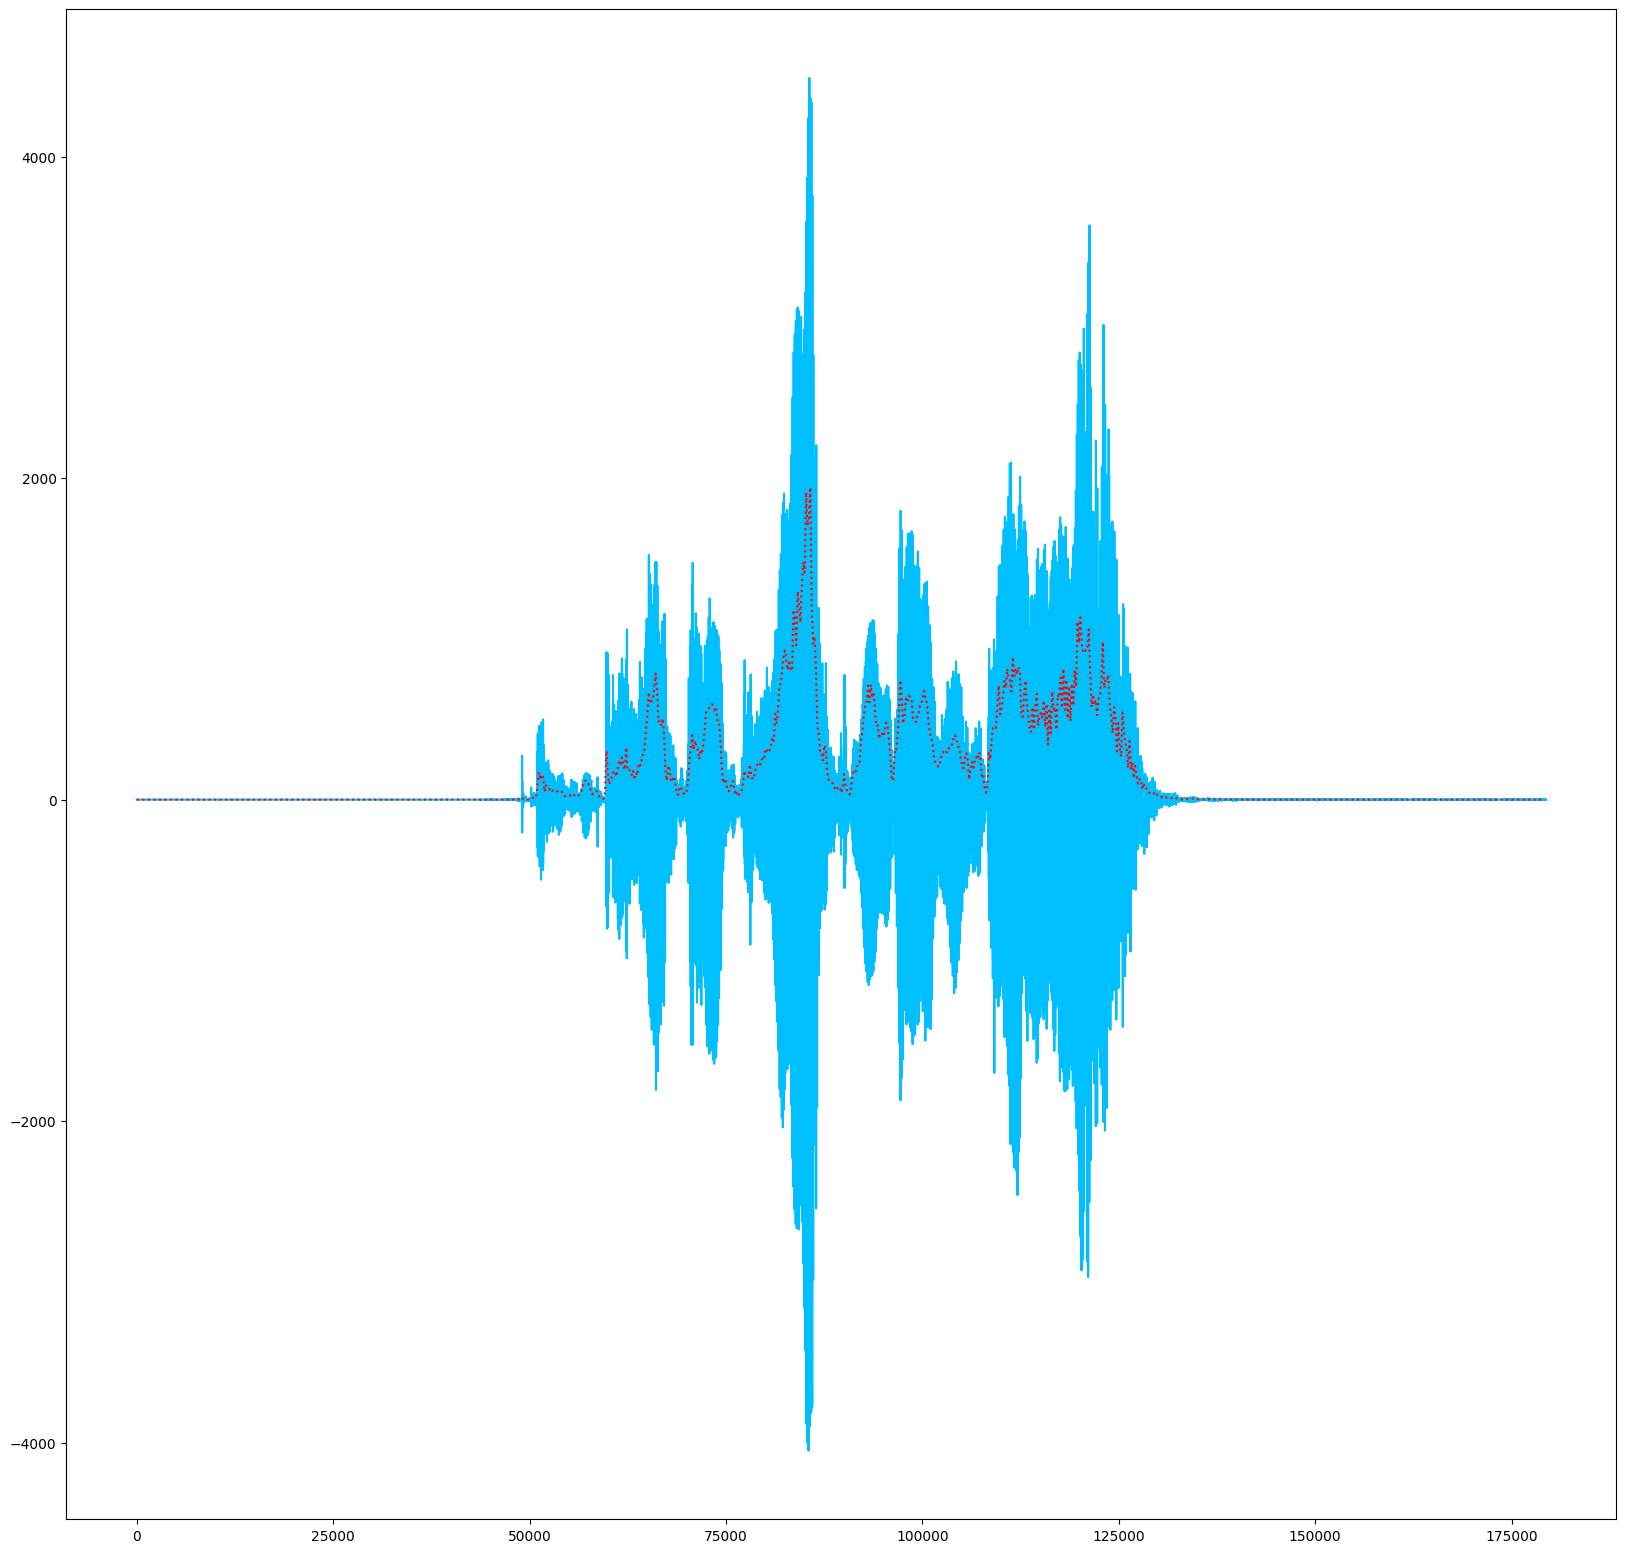

In [27]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["figure.dpi"] = 100
freq_sample, sig_audio = wavfile.read('03-01-05-01-01-02-20_A20.wav')

n = 1000
N = len(sig_audio)
m = round(N / n)
y = []
x = []
x_sig = []

print("N:", N)

for j in range(0, n):
    sum = 0
    for k in range(m * j, m * j + m):
        sum += abs(sig_audio[k])
    sum = sum / m
    y.append(sum)
    x.append(j * m)

for i in range(0, len(sig_audio)):
    x_sig.append(i)

    
plt.plot(x_sig, sig_audio, color = '#00bfff')
plt.plot(x, y, color = "red", linestyle = "dotted")

## Фильтрация, получение фильтрованного сигнала 

Был выбран ФНЧ.

Пусть $F_d$ - частота дискретизации, частота среза - $F_s$. порядок фильтра - $m$.

Тогда $wn = 2 {F_s \over F_d}$

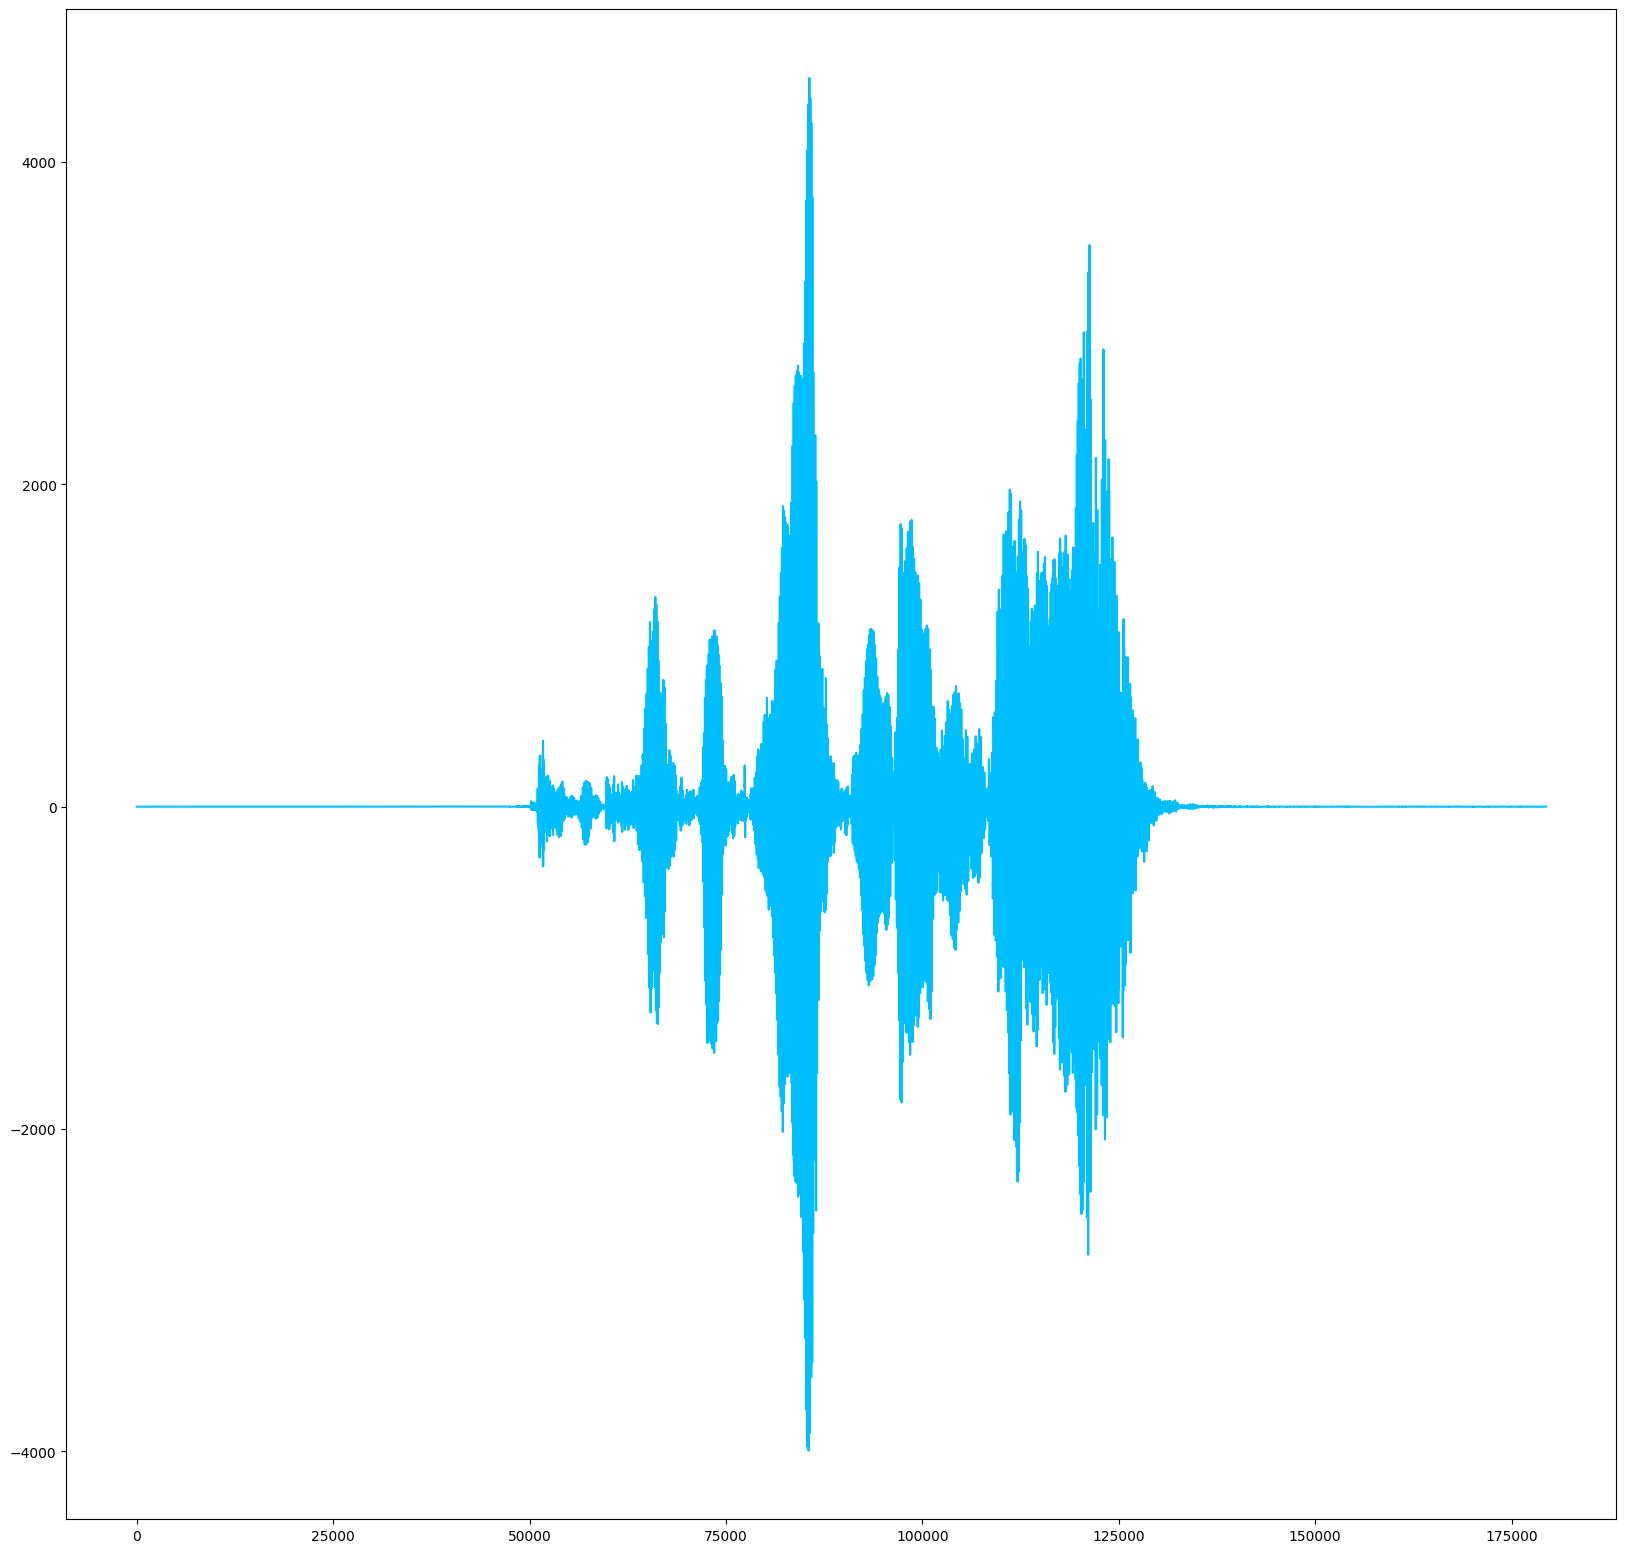

In [47]:
from scipy import signal

wn = 2 * (2000 / freq_sample)
m_deg = 15

b,a = signal.butter(m_deg, wn, 'lowpass')
filtedData = signal.filtfilt(b, a, sig_audio)

plt.plot(x_sig, filtedData, color='#00bfff')

wavfile.write("example.wav",freq_sample, filtedData.astype(np.int16))

import IPython
IPython.display.Audio(filtedData, rate = freq_sample)

После обработки ФНЧ звук стал более глухим, будто слышишь его из-под воды. Также видно, что график немного изменил свою форму.

## Амплитудный детектор сигнал/шум

Среднее сигнала по амплитуде: $mid ={1 \over N} \sum\limits_{k=0}^{N-1} |x(k)|$

Порог детектора $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментальным путем.

Задается величина провала $k$ (в отсчетах). $y(j)$ - сигнал после детектирования.

Сигнал начинается, если $x(i)$ в течении $k$ отсчетов превышает порог, тогда $y(i) = x(i)$.

Сигнал заканчивается, если $x(i)$ в течении $k$ отсчетов меньше порога, тогда $y(i) = 0$.

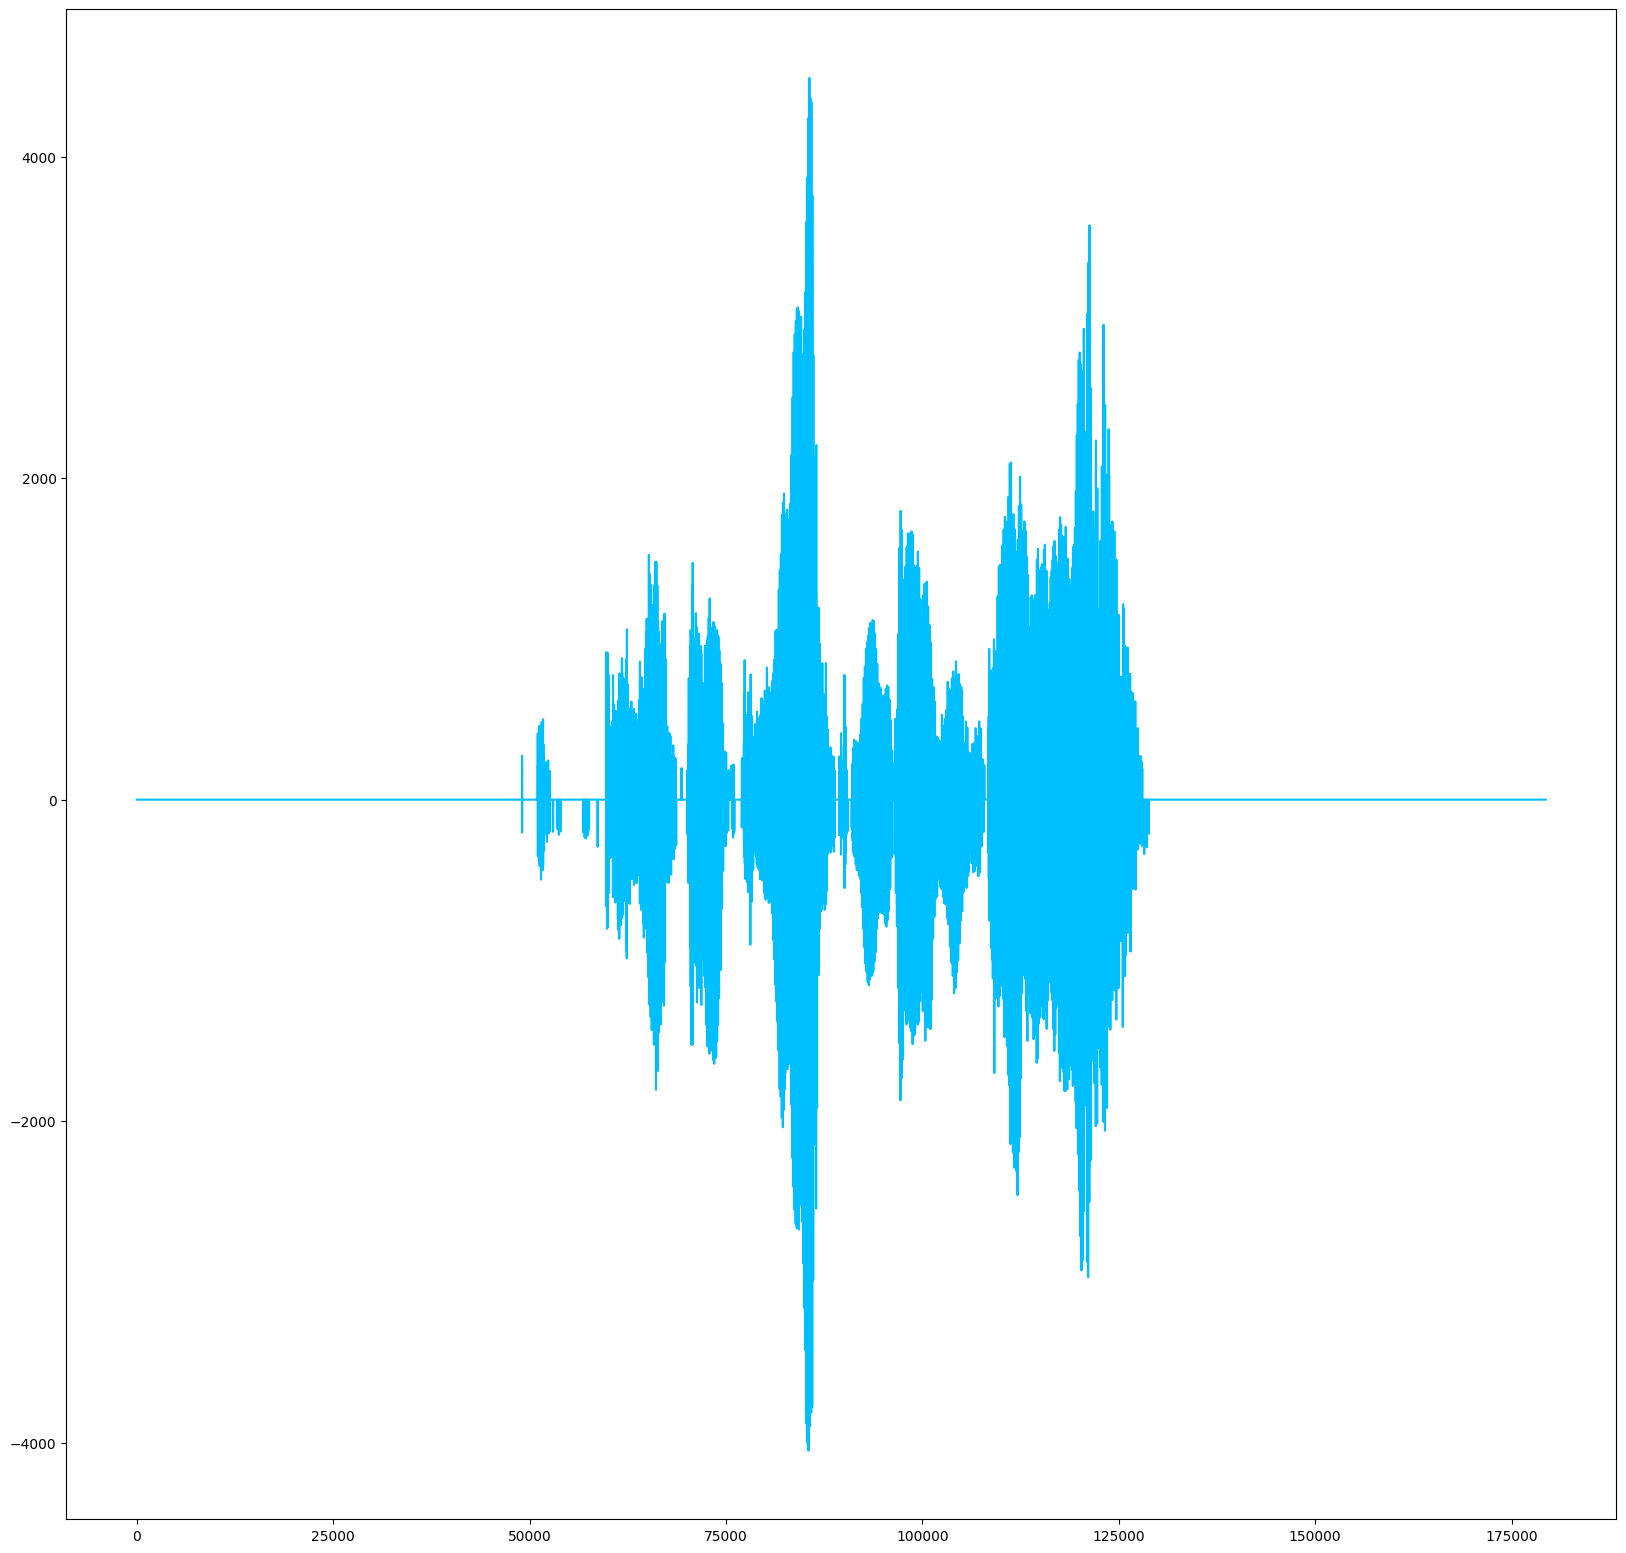

In [57]:
mid = 0
Th = 0

def checkNext(j, gap, data, Th, needStart):
    for i in range(j,j+gap):
        if needStart:
            if abs(data[i]) < Th:
                return False
        else:
            if abs(data[i]) >= Th:
                return False
    return True


for k in range(0, N):
    mid += abs(sig_audio[k])
mid /= N

alpha = 0.99

Th = mid*alpha
down = 1
new_signal = []
j = 0
start = False


while j < N:
    if abs(sig_audio[j]) >= Th:
        if not start:
            if checkNext(j, down, sig_audio, Th, not start):
                new_signal.append(sig_audio[j])
                start = True
            else:
                new_signal.append(0)
        else:
            new_signal.append(sig_audio[j])
    else:
        if start:
            if checkNext(j, down, sig_audio, Th, not start):
                new_signal.append(0)
                start = False
            else:
                new_signal.append(sig_audio[j])
        else:
            new_signal.append(0)
    j+=1

    
plt.plot(x_sig, new_signal, color='#00bfff')                
            
wavfile.write("example2.wav",freq_sample, np.array(new_signal).astype(np.int16))

import IPython
IPython.display.Audio(np.array(new_signal).astype(np.int16), rate=freq_sample)

После применения детектора в сигнале появился шум помех, также изменился и график звука.

## Эхо (простейший ревербератор)

Ревербератор состоит из 8 линий задержки. Каждая линия задержки имеет свой весовой коэффициент. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка. Соотношение между начальным и обработанным сигналом задается коэффициентом применимости $\gamma$.

Значения задержек: $D_i = D_1 * 2^{(1-i)/N_L}, i = 2,...,N_L$

Весовые коэффициенты при линиях задержек: $\alpha_i = {\alpha_1 / {2^{i}}}$

In [81]:
d = [20000]
j = 0
Nl = 8
delayed_signals = []
start_signal = sig_audio

def mult(sig, j):
    for i in range(0, len(sig)):
        sig[i] *= tilda[j]
    return sig


for i in range(2, 9):
    d.append(round(d[0] * 2**((1-i) / Nl)))
tilda = [0.9 / (2**(i)) for i in range(0, Nl)]


for di in d:
    sig = [0] * di
    sig.extend(start_signal)
    delayed_signals.append(mult(sig, j))
    j += 1

delayed_signal = delayed_signals[0]
for i in range(1,8):
    for j in range(0, len(delayed_signals[i])):
        delayed_signal[j] += delayed_signals[i][j]

filtedDelayed = signal.filtfilt(b,a,delayed_signal)    

for i in range(0, len(filtedDelayed)):
    filtedDelayed[i] *= 0.8
    
for i in range(0, len(start_signal)):
    filtedDelayed[i] += start_signal[i]
    
wavfile.write("example3.wav", freq_sample, np.array(filtedDelayed).astype(np.int16))

import IPython
IPython.display.Audio(np.array(filtedDelayed).astype(np.int16), rate=freq_sample)

После применения ревербератора на аудиозаписи появилось эхо.

## Классический Distortion

$x(i)$ - входной сигнал, $y(i)$ - выходной сигнал, где $i = 0, 1, ..., N-1$.

$Th$ - порог, $max$ - максимальное значения сигнала, где $max > Th$

Тогда $Y(i) = \begin{cases} x(i), |x(i)| \leqslant Th \\ max*sign(x(i)), |x(i)| > Th \end{cases}$

/tmp/ipykernel_236591/1671464011.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


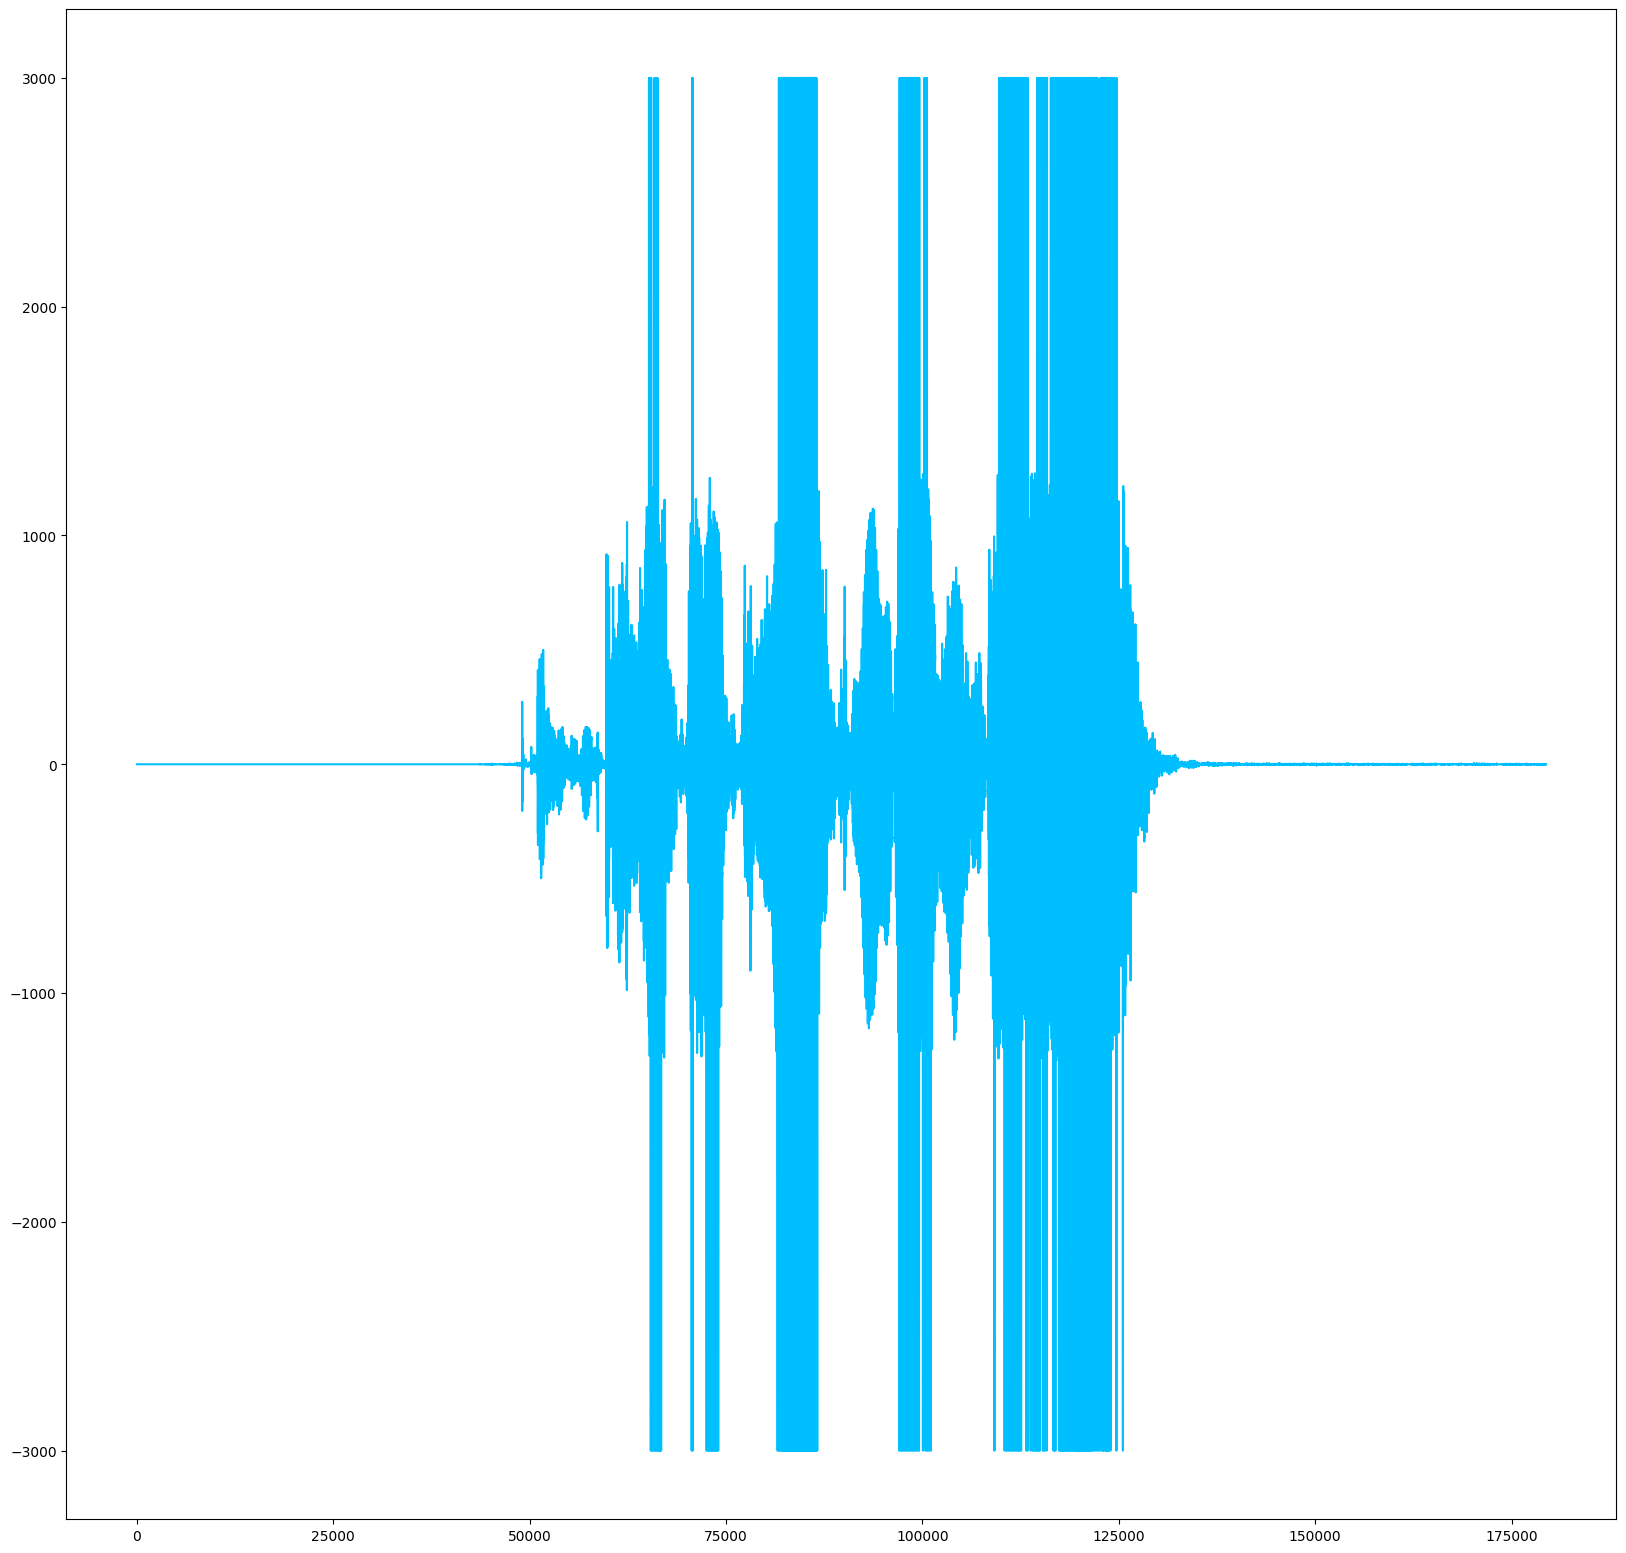

In [88]:
Th = 1300
maxTh = 3000
distortion_signal = []
sign = lambda x: (1, -1)[x<0]

for i in range(0,len(sig_audio)):
    if abs(sig_audio[i]) <= Th:
        distortion_signal.append(sig_audio[i])
    else:
        distortion_signal.append(maxTh*sign(sig_audio[i]))
        
plt.plot(x_sig, distortion_signal, color='#00bfff') 

wavfile.write("example4.wav", freq_sample, np.array(distortion_signal).astype(np.int16))

import IPython
IPython.display.Audio(np.array(distortion_signal).astype(np.int16), rate=freq_sample)

После применения классического Distortion изменения в звуке слышны, а также видны на графике. В местах, где звук был больше Th, он возрос до maxTh, в остальных - остался прежним.

## Вывод

Были изучены возможности Python для работы с цифровыми сигналами. Был изучен Jupiter Notebook. Была выполнена загрузка цифрового сигнала с проведением над ним следующих действий: построение графика огибающей, фильтрация сигнала, построение детектора сигнал/шум, реализация и наложение эффектов "Эхо" и "Distortion".

